# Classification customizing the architecture

# Step 1: Connect to Google Drive

In [1]:
# Mount Google drive to access dataset
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


# Step 2: Import required packages

In [2]:
# import required packages
import os
import tensorflow as tf
import zipfile
from tensorflow.keras import layers
from tensorflow.keras import Model
from sklearn.preprocessing import LabelBinarizer
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD
from keras.datasets import cifar10
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np


In [3]:
from keras.utils import plot_model

# Step 3: Peform transfer learning using Resnet50 (architecture) and imagenet (weights and biases), removing 3 residual blocks

In [4]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import models, layers, optimizers

# Load the ResNet50 model
conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base2 = Model(conv_base.input, conv_base.layers[-33].output)

print("Original ResNet50 summary:")
conv_base.summary()

conv_base2.summary()

94765736/94765736 [==============================] - 3s 0us/step
Original ResNet50 summary:
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  

# Step 4: Show an image of the CONV layers of ResNet50 model before removing 3 residual blocks

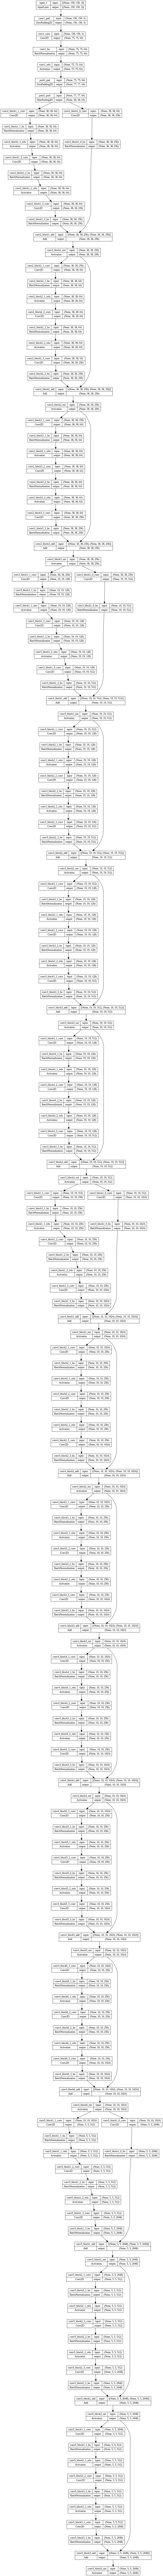

In [5]:
plot_model(conv_base, to_file='model.png', show_layer_names=True, show_shapes=True, rankdir='TB')

# Step 5: Show an image of the CONV layers of ResNet50 model after removing 3 residual blocks

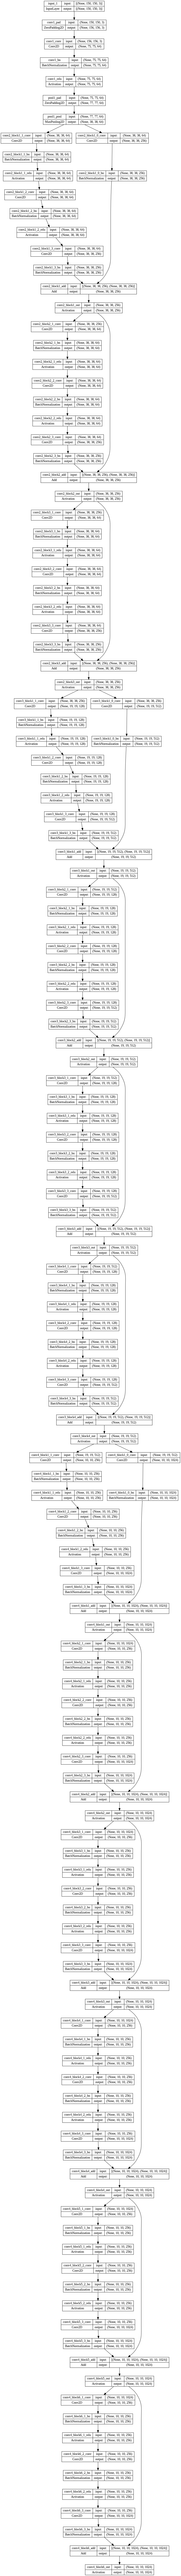

In [6]:
plot_model(conv_base2, to_file='model.png', show_layer_names=True, show_shapes=True, rankdir='TB')

# Step 6: Load the CONV layers of ResNet50 model and add the FC layers

In [7]:
model = models.Sequential()
model.add(conv_base2)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(20, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 10, 10, 1024)      8589184   
                                                                 
 flatten (Flatten)           (None, 102400)            0         
                                                                 
 dense (Dense)               (None, 256)               26214656  
                                                                 
 dense_1 (Dense)             (None, 20)                5140      
                                                                 
Total params: 34,808,980
Trainable params: 34,778,388
Non-trainable params: 30,592
_________________________________________________________________


# Step 8: Use image generator to load images, generate labels automatically and perform image augmentation

In [8]:
train_dir = '/content/gdrive/MyDrive/Image_Classification/output/train'
validation_dir = '/content/gdrive/MyDrive/Image_Classification/output/val'
test_dir = '/content/gdrive/MyDrive/Image_Classification/output/test'

In [9]:
# Updated to do image augmentation
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)


# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # We use 'categorical', with one-hot encoding, we get mutually exclusive labels (We can't have 2 kinds of dog at the same time)
        class_mode='categorical')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

Found 2537 images belonging to 20 classes.
Found 311 images belonging to 20 classes.
Found 336 images belonging to 20 classes.


# Step 9: Compile the model

In [10]:
from tensorflow.keras.optimizers import Adam

In [11]:
from tensorflow.keras.optimizers.legacy import Adam


In [12]:
# 'sparse_categorical_crossentropy' is used because we have multiple mutually exclusive labels
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-4),
              metrics=['acc'])

# Step 10: Save snapshots of the model as checkpoints

In [ ]:
filepath='/content/gdrive/MyDrive/Image_Classification/output/weights.{epoch:02d}-{val_loss:.2f}.hdf5'
checkpoint=tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

# Step 11: Train the model

In [ ]:
# Train the model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=126,  # 2537 images = batch_size * steps. This division doesn't give an exact number. Ok to round?
      epochs=50,
      validation_data=validation_generator,
      validation_steps=15, # 311 images = batch_size * steps
      callbacks = [checkpoint],
      verbose=2)

<ipython-input-13-dc766c12b46e>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
126/126 - 176s - loss: 2.7402 - acc: 0.3151 - val_loss: 6.8242 - val_acc: 0.0567 - 176s/epoch - 1s/step
Epoch 2/50
126/126 - 33s - loss: 1.1377 - acc: 0.6528 - val_loss: 5.9400 - val_acc: 0.0533 - 33s/epoch - 265ms/step
Epoch 3/50
126/126 - 36s - loss: 0.6384 - acc: 0.7994 - val_loss: 4.6324 - val_acc: 0.0400 - 36s/epoch - 284ms/step
Epoch 4/50
126/126 - 36s - loss: 0.5234 - acc: 0.8383 - val_loss: 3.4141 - val_acc: 0.1133 - 36s/epoch - 283ms/step
Epoch 5/50
126/126 - 35s - loss: 0.3956 - acc: 0.8701 - val_loss: 3.7545 - val_acc: 0.1467 - 35s/epoch - 278ms/step
Epoch 6/50
126/126 - 35s - loss: 0.3789 - acc: 0.8852 - val_loss: 3.4231 - val_acc: 0.2700 - 35s/epoch - 280ms/step
Epoch 7/50
126/126 - 34s - loss: 0.2956 - acc: 0.9070 - val_loss: 1.5432 - val_acc: 0.5767 - 34s/epoch - 271ms/step
Epoch 8/50
126/126 - 35s - loss: 0.2184 - acc: 0.9285 - val_loss: 0.8633 - val_acc: 0.7733 - 35s/epoch - 280ms/step
Epoch 9/50
126/126 - 36s - loss: 0.2751 - acc: 0.9166 - val_loss: 0.3794 

Considering the model's best epoch in terms of validation accuracy (Epoch 9):

**Validation accuracy : 0.9100**
**Validation loss: 0.3794**

**Training accuracy : 0.9166**
**Training loss: 0.2751**

# Step 12: Visualize results

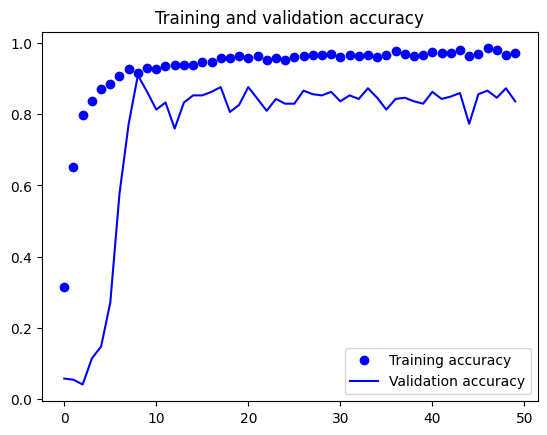

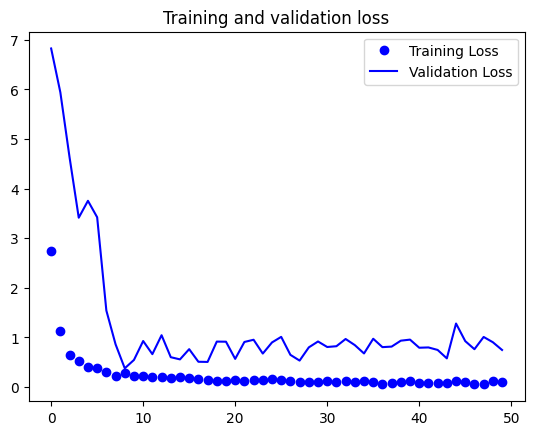

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Step 13: Evaluate on test dataset

In [13]:
## Load the model with the weights of the best epoch
model_loaded=tf.keras.models.load_model('/content/gdrive/MyDrive/classification_the_last/weights.09-0.38.hdf5')

In [14]:
model_loaded.evaluate(test_generator)

17/17 [==============================] - 76s 4s/step - loss: 0.5210 - acc: 0.8601


[0.5209778547286987, 0.8601190447807312]

Using the weights of the model's best epoch in terms of validation accuracy (Epoch 9):

**Test accuracy: 0.8601**
**Test loss: 0.5201**